In [1]:
import numpy as np
from PIL import Image
from bitarray import bitarray
import heapq
import os
import struct
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import cv2

In [2]:
class HeapNode:

    # Object constructor
    def __init__(self, freq, rgb_vals):

        # Object variables
        self.rgb_vals = rgb_vals
        self.freq = freq
        self.left = None
        self.right = None


    # Public functions
    def __eq__(self,other):
        return HeapNode.__check(other) and self.freq == other.freq

    def __ne__(self,other):
        return HeapNode.__check(other) and self.freq != other.freq

    def __lt__(self,other):
        return HeapNode.__check(other) and self.freq < other.freq

    def __le__(self,other):
        return HeapNode.__check(other) and self.freq <= other.freq

    def __gt__(self,other):
        return HeapNode.__check(other) and self.freq > other.freq

    def __ge__(self,other):
        return HeapNode.__check(other) and self.freq >= other.freq

    @staticmethod
    def __check(other):
        if other is None:
            return False
        if not isinstance(other,HeapNode):
            return False

        return True

In [3]:
class Huffman:

    # Constructor
    def __init__(self,path=None,reso_partial=None,num_diff_vals=None):
        # reso_partial 
        
        self.path = path
        self.img_array = None

        if(path != None):
            self.img_array = np.array(Image.open(self.path))

            # Shape of rgb image is (rows,columns,3)
            self.rows = self.img_array.shape[0]
            self.columns = self.img_array.shape[1]
            if (self.img_array.shape[2] != 3):
                print(self.img_array.shape)
                print('File is not an acceptable rgb image.')
                exit(0)

        # Structures
        self.heap = []
        self.encoded = {}
        self.freq = {}
        self.reso_partial = reso_partial
        self.num_diff_vals = num_diff_vals




    ## Functions for running tests
    def test_img(self,filename):


        if (self.reso_partial != None) and (self.num_diff_vals != None):
            self.compress()

        root = self.decode_codebook()
        self.print_tree(root)


        # print 'Number of colors in image:',len(freq)

        img = Image.fromarray(self.img_array)
        if filename.endswith('.jpg'):
            new_filename = filename[:len(filename)-4]+'_degredated.jpg'
            img.save('/images/export/' + new_filename)
        else:
            img.save('/images/export/not-jpg.jpg')


    def print_tree(self,root,code=''):

        if(not isinstance(root,HeapNode)): return

        if(isinstance(root.left,HeapNode) or isinstance(root.right,HeapNode)):

            leftChild = root.left
            rightChild = root.right

            if(root.left != None):
                self.print_tree(leftChild,code +'0')

            if(root.right != None):
                self.print_tree(rightChild,code + '1')

            return

        print ('Reached rgb_val: ', root.rgb_vals)
        print(code)








    ## Compression functions

    # Increase the frequency of colors / image loss
    def degradation(self):

        # Precision variables
        # (MAYBE: make precision variables a function of the size of the image)
        
        reso_size = self.reso_partial 
        num_diff_vals = self.num_diff_vals


        total_num_colors = (num_diff_vals+1)^3
        prec_size = 255.0 / num_diff_vals
        remaining_rows = self.rows % reso_size


        # Set the color of each (reso_size x 1) column to average color of that column
        # Truncate the values by integer division
        for i in range(0,self.rows-remaining_rows,reso_size):

            for j in range(self.columns):
                valRed = np.array([self.img_array[k][j][0] for k in range(i,i+reso_size)])
                avgRed = valRed.mean()

                valGreen = np.array([self.img_array[k][j][1] for k in range(i,i+reso_size)])
                avgGreen = valGreen.mean()

                valBlue = np.array([self.img_array[k][j][2] for k in range(i,i+reso_size)])
                avgBlue = valBlue.mean()

                avgRGB = [avgRed,avgGreen,avgBlue]
                avgRGB[:] = [int(x) - int(x)%prec_size for x in avgRGB]
                # print(avgRGB,i,j)

                for l in range(i,i+reso_size):
                    self.img_array[l][j] = avgRGB

        # If any rows are left at bottom of image, then finish
        if (remaining_rows != 0):

            for j in range(self.columns):
                valRed = np.array([self.img_array[k][j][0] for k in range(i,self.rows)])
                avgRed = valRed.mean()

                valGreen = np.array([self.img_array[k][j][1] for k in range(i,self.rows)])
                avgGreen = valGreen.mean()

                valBlue = np.array([self.img_array[k][j][2] for k in range(i,self.rows)])
                avgBlue = valBlue.mean()

                avgRGB = [avgRed,avgGreen,avgBlue]
                avgRGB[:] = [int(x) - int(x)%prec_size for x in avgRGB]

                for l in range(i,self.rows):
                    self.img_array[l][j] = avgRGB


    def create_huffman_tree(self):
        freq_dict = self.fill_freq_dict()
        self.make_heap(freq_dict)
        self.merge_nodes()


    def fill_freq_dict(self):

        frequency = {}

        for i in range(self.rows):
            pixels = self.img_array[i]

            for j in range(self.columns):
                rgb_val = pixels[j]

                key = (rgb_val[0],rgb_val[1],rgb_val[2])
                if (key not in frequency):
                    frequency[key] = 0

                frequency[key] += 1
        
        self.freq = frequency
        
        return frequency


    def make_heap(self, frequency):

        for key in frequency:
            node = HeapNode(frequency[key],key)
            heapq.heappush(self.heap, node)


    def merge_nodes(self):
        while(len(self.heap)>1):
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)

            merged = HeapNode(node1.freq + node2.freq, None)
            merged.left = node1
            merged.right = node2

            heapq.heappush(self.heap, merged)




    def create_binfile(self,bin_str=''):
        ##      Schema:
        ##          [# leaves][encoded tree][# of columns][encoded img]
        ##          [uint16][{(uint8,uint8,uint8),uint16,x-bits}][uint16][x-bits]


        file = open('encoded.bin','wb')

        num_leaves = len(self.encoded)
        file.write(num_leaves.to_bytes(2,'little'))

        for key in self.encoded:
            file.write(key[0].to_bytes(1,'little'))
            file.write(key[1].to_bytes(1,'little'))
            file.write(key[2].to_bytes(1,'little'))

            code_len = len(self.encoded[key])
            file.write(code_len.to_bytes(2,'big'))

            padding = '0' * code_len % 8
            code_str = self.encoded[key] + padding
            file.write(bitarray(code_str))

        file.write(self.columns.to_bytes(2,'big'))
        file.write(bitarray(bin_str))

        file.close()



        # Create first half of .bin file
        self.fill_code_dict()
        self.encode_huffman_tree({})


        # Create second half of .bin file
        self.create_code()


        # Save .bin file

        output_path = ''

        return output_path


    def fill_code_dict(self):
        root = heapq.heappop(self.heap) #root node of huffman tree
        curr_code = "" #stores current code as huffman tree is traversed
        self.fill_code_dict_helper(root,curr_code) #occupy codebook w huffman codes
    
    
    def fill_code_dict_helper(self,root,curr_code):
        if root == None:
            return

        if root.rgb_vals != None: #leaf node - save code to cookbook
            self.encoded[root.rgb_vals] = curr_code
            return

        self.fill_code_dict_helper(root.left,curr_code + "0") #internal node - append 0 and traverse left
        self.fill_code_dict_helper(root.right,curr_code + "1") #internal node - append 1 and traverse right
        

    def encode_huffman_tree(self,code_dict):
            pass

        
    #iterate through img_array and translate each (r,g,b) to huffman code, return final huffman encoding
    def create_code(self):
        #save_file = open("../images-compressed/encoding.txt",'w') #file to write encoding to
        curr_code = ""
        for row in range(0,self.rows):
            for column in range(0,self.columns):
                curr_pixel = self.img_array[row,column]
                key = (curr_pixel[0],curr_pixel[1],curr_pixel[2])
                curr_code += self.encoded[key]
                #print(self.encoded[key], end=" ")
                #save_file.write(self.encoded[key])
                #save_file.write(' ')
        #save_file.close()
        return curr_code


    def compress(self):
        self.degradation()
        self.create_huffman_tree()
        output_path = self.create_binfile()

        return output_path







    ## Decompression
    def decode_binfile(self):

        # Decoding first then second half of the .bin file
        self.decode_codebook()
        self.decode_binary()


    def decode_codebook(self):
        # [uint] [(uint, uint, bits)...] = A (a1, a2, a3)...(n1,n2,n3)]
        # where A is the number of total groupings/leaf nodes 
            pass


    def reconstruct_tree(self,codebook=None):
        root = HeapNode(None,None)

        for key in codebook:
            self.insert_leaf(root,key,0,codebook[key])

        return root



    def insert_leaf(self,root,code,index,rgb_vals):
        if (len(code) == index):
            root.rgb_vals = rgb_vals

        else:
            if(code[index] == '0'):
                if(not isinstance(root.left,HeapNode)):
                    root.left = HeapNode(None,None)

                self.insert_leaf(root.left,code,index+1,rgb_vals)


            elif(code[index] == '1'):
                if(not isinstance(root.right,HeapNode)):
                    root.right = HeapNode(None,None)

                self.insert_leaf(root.right,code,index+1,rgb_vals)





    def decode_binary(self,code,root,num_columns):


        curr = root
        row_count = 0;


        for i in range(len(code)):


            if(code[i] == '1'): curr = curr.right
            elif(code[i] == '0'): curr = curr.left

            if(curr.left == None and curr.right == None):
                self.insert_rgb2mtx(curr.rgb_vals,row_count)

                if(i % (num_columns-1) == 0):
                    ++row_count




    def insert_rgb2mtx(self,rgb_tuple,row):

        rgb_vals = np.asarray(rgb_tuple)
        np.append(self.img_array[row],rgb_vals)

        
        
        
    def array_to_img(self):
        # use decode_binary and convert into numpy array (decode_binary used in decompress())
        # get the root node from huffman tree and the strings of 0s and 1s
        # heapnode, string, int (rows)

        bin_string = bin_numbers

#         for i in range(HeapNode(None,None), rows-rows_left, reso_size):

#             for j in range(0,columns):
                
#                 if (bin_string is a certain value)
#                     RGB_Red = np.fromstring(bin_string)
                    
#                 if (bin_string is a certain value)
#                     RGB_Green = np.fromstring(bin_string)

#                 if (bin_string is a certain value)    
#                     RGB_Blue =  np.fromstring(bin_string)

#                     pix = [RGB_Red, RGB_Green, RGB_Blue]


        #turn numpy array into an img
        img = Image.fromarray(pix)
        img.save('/images/export/reduced_quality.jpg')


        
    def decompress(self):
            pass


In [4]:
#-=-=-=-=-=-=-=-=-= Main Function =-=-=-=-=-=-=-=-

# Enter whatever .jpg file from images folder
# Expect degredated image in export folder

# plains.jpg, mountains.jpg, van_gogh.jpg, colorful.jpg, simple.jpg

filename = 'mountains.jpg'

path = '/images/' + filename
h = Huffman(path,1,10) #Huffman(img_name, 1<pixel binning<#rows, 1<color binning<255)
h.test_img(filename)


In [5]:
bin_length_Huff = 0
for rgb_key in h.encoded:
    bin_length_Huff += h.freq[rgb_key] * len(h.encoded[rgb_key])
print('bin_length_Huff:',bin_length_Huff)

bin_length_Original = h.rows * h.columns * 24
print('bin_length_Original:',bin_length_Original)


if bin_length_Huff < bin_length_Original:
    print('Huffman Algorithm is better')
else:
    print('Orginal is better')

bin_length_Huff: 2339117
bin_length_Original: 9910080
Huffman Algorithm is better


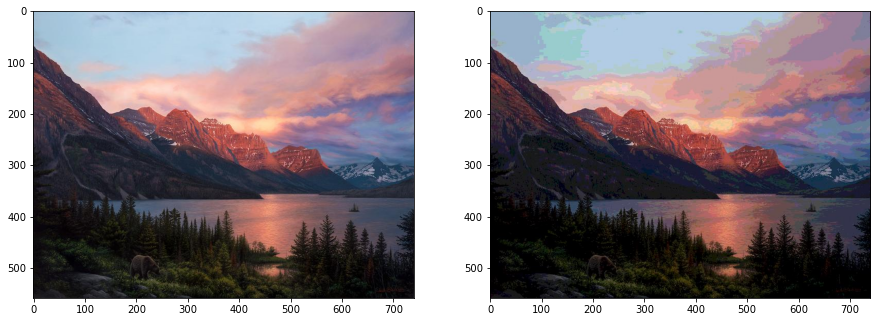

In [6]:
plt.figure(figsize=(15, 10))

temp_img=cv2.imread(path)
img_original=cv2.cvtColor(temp_img,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1); plt.imshow(img_original)

new_filename = filename[:len(filename)-4]+'_degredated.jpg'
temp_img=cv2.imread('/images/export/' + new_filename)
img_new=cv2.cvtColor(temp_img,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2); plt.imshow(img_new)

plt.show()